In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

# Water model development

The goal of this notebook is develop and improve the water model.

## Data

In [2]:
from data_utils.database import select_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

from data_utils.utils import data_dict_from_df_tables, get_X_y_from_data
from ggmodel.validation import score_model_dictionnary, score_model, plot_diagnostic, make_baseline_computation_df, agg_score_by
from models.water.EW import model_dictionnary

plt.style.use('ggplot')

def prepare_water_model_data():

    # Select dataset
    df_tables = ["aquastat", 'worldbank', 'evapotranspiration', 'cropcalendar', 'efficientwater', 'sarahcrops']

    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    # Preprocess some datasets
    df_dictionnary['cropcalendar'] = df_dictionnary['cropcalendar'].drop(columns=['Year'])
    df_dictionnary['aquastat'] = df_dictionnary['aquastat'][~df_dictionnary['aquastat'].Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
    df_dictionnary['sarahcrops'] = df_dictionnary['sarahcrops'][~df_dictionnary['sarahcrops'].Variable.isin(['ICA', 'CI'])]


    # Convert to model readable datadict
    data_dict = data_dict_from_df_tables([df for _, df in df_dictionnary.items()])

    ISOs = df_dictionnary['aquastat'].ISO.unique()
    
    # Impute missing values
    def preprocess_dict_item(key, value):
        mux = pd.MultiIndex.from_product([ISOs, range(2000, 2020)],
                                     names=['ISO', 'Year'])

        if key in ['ICA', 'Kc']:
            return value
        else:
            return (
                  value.reindex(mux)
                      .groupby(level='ISO')
                      .fillna(method='ffill')
                      .groupby(level='ISO')
                      .fillna(method='bfill')
                      .fillna(0))


    data_dict = {k: preprocess_dict_item(k, v).sort_index() for k, v in data_dict.items()} # comment here for raw data

    return data_dict

data_dict = prepare_water_model_data()

## Model

In [3]:
scores = score_model_dictionnary(model_dictionnary, data_dict)

IWW_model: Done
EW1_partial_model: Done
EW2_partial_model: Done
EW1_model: 

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done
EW2_model: 

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done
EW_model: 

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done


In [4]:
scores['EW1_model']['score_by_ISO_Variable'].loc['FRA']

,r2,correlation,rmse
Variable,,,
AWU,0.194690,0.876024,0.264556
EW1,0.781368,0.933816,21.248151
IWR,0.000000,NaN,0.041338
IWW,-0.525679,0.852289,1.015427
MWU,-71.252074,-0.932467,6.792983
TWW,-0.818534,0.971496,10.603534


## Scenario

In [5]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from ggmodel.projection import *

In [8]:
def run_water_projection(data_dict):

    projection_dict = {
        'IGVA': lambda x: apply_Holt_projection(x),
        'SGVA': lambda x: apply_Holt_projection(x),
        'AGVA': lambda x: apply_Holt_projection(x),
        'GDPC': lambda x: apply_Holt_projection(x),
        'Pop': lambda x: apply_Holt_projection(x),
        'AIR': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'CL': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'Arice': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'ETo': lambda x: apply_ffill_projection(x),
        'ETa': lambda x: apply_ffill_projection(x),
        'IRWR': lambda x: apply_ffill_projection(x),
        'ERWR': lambda x: apply_ffill_projection(x),
        'IWU': lambda x: apply_ffill_projection(x),
        'DW': lambda x: apply_ffill_projection(x),
        'TW': lambda x: apply_ffill_projection(x),
        'EFR': lambda x: apply_ffill_projection(x),
     }

    return run_projection(projection_dict, data_dict)


def run_water_scenario(data_dict, WP_rate=1.05, WRR_rate=1.01):

    data_dict = data_dict.copy()

    projection_dict = {
        'WP': lambda x: apply_annual_rate_projection(x, WP_rate),
        'WRR': lambda x: apply_annual_rate_projection(x, WRR_rate),
    }

    data_dict = run_projection(projection_dict, data_dict)

    results = model_dictionnary['EW_model'].run(data_dict)

    return results

In [9]:
ISO_data_dict = {k: v.loc[['FRA'], :] for k, v in data_dict.items()}

proj_ISO_data_dict = run_water_projection(ISO_data_dict)

s_1 = run_water_scenario(proj_ISO_data_dict, WP_rate=1.05, WRR_rate=1.01)
s_2 = run_water_scenario(proj_ISO_data_dict, WP_rate=1.1, WRR_rate=1.01)
s_3 = run_water_scenario(proj_ISO_data_dict, WP_rate=0.9, WRR_rate=1.01)

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


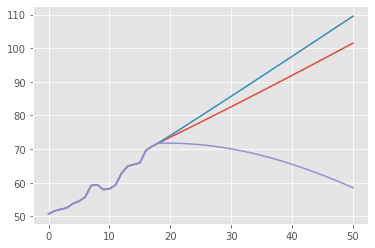

In [10]:
plt.plot(s_1['EW1'].values)
plt.plot(s_2['EW1'].values)
plt.plot(s_3['EW1'].values)

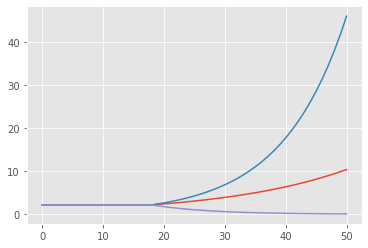

In [11]:
plt.plot(s_1['WP'].values)
plt.plot(s_2['WP'].values)
plt.plot(s_3['WP'].values)